# DeepONet for Acoustic Wave Propagation - Solutions

**PhD Autumn School - Scientific Machine Learning**

This notebook contains the complete implementation with all TODOs filled in.
Use this to verify everything works before distributing the student version.

## Learning Objectives

In this 1-hour hands-on exercise, you will:
1. Understand the DeepONet architecture for operator learning
2. Implement branch and trunk networks in PyTorch
3. Implement the inner product operation that combines branch and trunk outputs
4. Compare different activation functions (ReLU vs Sine)
5. Investigate the impact of Fourier feature expansions

## Introduction to DeepONet

**Deep Operator Networks (DeepONet)** learn operators that map functions to functions, rather than just vectors to vectors like traditional neural networks.

### The Problem

In acoustic wave propagation, we want to learn the operator $\mathcal{G}$ that maps:
- **Input function** $u(x)$: Initial pressure distribution (source configuration)
- **Output function** $s(x, y, t)$: Pressure field at any location $(x, y)$ and time $t$

Mathematically: $s = \mathcal{G}(u)$

### DeepONet Architecture

```
                    ┌─────────────┐
u(x) ─────────────> │ Branch Net  │ ───> [b₁, b₂, ..., bₚ]
  (function)        └─────────────┘            │
                                               │
                                               ├──> Inner Product ──> s(y)
                                               │
y = (x,y,t) ────> ┌─────────────┐            │
  (coordinates)   │  Trunk Net  │ ───> [t₁, t₂, ..., tₚ]
                  └─────────────┘
```

- **Branch network**: Encodes the input function $u$ into a latent representation
- **Trunk network**: Encodes the query coordinates $(x, y, t)$
- **Inner product**: Combines both representations: $s(y) = \sum_{i=1}^{p} b_i(u) \cdot t_i(y) + b_0$

### Key Insight

By learning this decomposition, the network can:
- Generalize to new source configurations $u$ (never seen during training)
- Evaluate at arbitrary query locations $(x, y, t)$
- Reduce computational cost compared to traditional PDE solvers

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Import project data handlers
from deeponet_acoustics.datahandlers.datagenerators import (
    DataH5Compact,
    DatasetStreamer,
    pytorch_collate  # PyTorch collator for data loading
)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.8.0
Device: cpu


## 1. Data Loading

In [5]:
# NOTE: Update these paths to point to your data
train_data_path = "/Users/nikolasborrel/data/deeponet/data/input2D_split/rect2x2_freq_indep_ppw_2_6_2_5_train"  # TODO: Update this path
test_data_path = "/Users/nikolasborrel/data/deeponet/data/input2D_split/rect2x2_freq_indep_ppw_2_4_2_val"       # TODO: Update this path

# Load training data
data_train = DataH5Compact(
    train_data_path,
    tmax=17, #0.015,      # Maximum time to consider
    t_norm=343.0,    # Speed of sound for normalization
    flatten_ic=True, # Flatten initial conditions
    norm_data=True,  # Normalize spatial coordinates
)

# Load test data
data_test = DataH5Compact(
    test_data_path,
    tmax=17, #0.015,
    t_norm=343.0,
    flatten_ic=True,
    norm_data=True,
)

print(f"Training sources: {data_train.N}")
print(f"Test sources: {data_test.N}")
print(f"Mesh points: {data_train.P_mesh}")
print(f"Time steps: {len(data_train.tsteps)}")
print(f"Input (u) shape: {data_train.u_shape}")

Estimating pressure min/max from 129 samples...
Pressure range: [0.0000, 0.9985]
Estimating pressure min/max from 9 samples...
Pressure range: [0.0000, 0.9985]
Training sources: 129
Test sources: 9
Mesh points: 1473
Time steps: 96
Input (u) shape: [324]


In [6]:
# Create datasets and dataloaders
batch_size_branch = 4    # Number of different sources per batch
batch_size_coord = 100   # Number of coordinate points per batch

dataset_train = DatasetStreamer(data_train, batch_size_coord=batch_size_coord)
dataset_test = DatasetStreamer(data_test, batch_size_coord=-1)  # Full dataset for testing

# Use pytorch_collate to convert to PyTorch tensors
dataloader_train = DataLoader(
    dataset_train,
    batch_size=batch_size_branch,
    shuffle=True,
    collate_fn=pytorch_collate,
    drop_last=True,
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=pytorch_collate,
)

# Get a sample batch to understand dimensions
sample_batch = next(iter(dataloader_train))
(u_sample, y_sample), s_sample, _, _ = sample_batch

print(f"\nBatch shapes:")
print(f"  u (branch input): {u_sample.shape}  # [batch_branch, u_dim]")
print(f"  y (trunk input):  {y_sample.shape}  # [batch_branch, batch_coord, coord_dim]")
print(f"  s (output):       {s_sample.shape}  # [batch_branch, batch_coord]")


Batch shapes:
  u (branch input): torch.Size([4, 324])  # [batch_branch, u_dim]
  y (trunk input):  torch.Size([4, 100, 3])  # [batch_branch, batch_coord, coord_dim]
  s (output):       torch.Size([4, 100])  # [batch_branch, batch_coord]


## 2. Fourier Feature Expansion

In [29]:
def fourier_feature_expansion(freqs=[]):
    """
    Create a Fourier feature expansion function.
    
    Args:
        freqs: List of frequencies for Fourier features
               Empty list means no Fourier features (just return input)
    
    Returns:
        Function that applies Fourier feature expansion
    """
    if len(freqs) == 0:
        return lambda y: y
    
    def expand(y):
        # y shape: [batch, coord_dim] or [batch, n_points, coord_dim]
        features = [y]
        for f in freqs:
            features.append(np.cos(2 * np.pi * f * y))
            features.append(np.sin(2 * np.pi * f * y))
        return np.concatenate (features, axis=-1)
    
    return expand

# Example: no Fourier features
feat_fn_none = fourier_feature_expansion(freqs=[])

# Example: with Fourier features at specific frequencies
feat_fn_fourier = fourier_feature_expansion(freqs=[1.0, 2.0])

# Test
test_input = np.random.rand(4, 3)  # [batch=4, coord_dim=3]
print(f"Input shape: {test_input.shape}")
print(f"Without Fourier features: {feat_fn_none(test_input).shape}")
print(f"With Fourier features: {feat_fn_fourier(test_input).shape}  # 3 + 2*2*3 = 15")

Input shape: (4, 3)
Without Fourier features: (4, 3)
With Fourier features: (4, 15)  # 3 + 2*2*3 = 15


## 3. Network Components - SOLUTIONS

In [30]:
class BranchNet(nn.Module):
    """
    Branch network for DeepONet.
    
    Architecture: input -> hidden -> hidden -> ... -> output
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers, activation='relu'):
        """
        Args:
            input_dim: Dimension of input function u
            hidden_dim: Number of neurons in hidden layers
            output_dim: Dimension of latent representation (p)
            num_hidden_layers: Number of hidden layers
            activation: 'relu' or 'sine'
        """
        super().__init__()
        
        layers = []
        
        # SOLUTION: First layer: input_dim -> hidden_dim
        layers.append(nn.Linear(input_dim, hidden_dim))
        
        # SOLUTION: Hidden layers: hidden_dim -> hidden_dim
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        # SOLUTION: Output layer: hidden_dim -> output_dim
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.layers = nn.ModuleList(layers)
        
        # Select activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sine':
            self.activation = lambda x: torch.sin(x)
        else:
            raise ValueError(f"Unknown activation: {activation}")
    
    def forward(self, u):
        """
        Forward pass through branch network.
        
        Args:
            u: Input function [batch_size, input_dim]
        
        Returns:
            Branch latent representation [batch_size, output_dim]
        """
        x = u
        
        # SOLUTION: Apply layers with activation (except last layer)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            # Don't apply activation after the last layer
            if i < len(self.layers) - 1:
                x = self.activation(x)
        
        return x

In [9]:
class TrunkNet(nn.Module):
    """
    Trunk network for DeepONet.
    
    Architecture: input -> hidden -> hidden -> ... -> output
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers, activation='relu'):
        """
        Args:
            input_dim: Dimension of coordinate input y (e.g., 3 for x,y,t)
            hidden_dim: Number of neurons in hidden layers
            output_dim: Dimension of latent representation (p) - must match branch output!
            num_hidden_layers: Number of hidden layers
            activation: 'relu' or 'sine'
        """
        super().__init__()
        
        layers = []
        
        # SOLUTION: Same structure as BranchNet
        layers.append(nn.Linear(input_dim, hidden_dim))
        
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.layers = nn.ModuleList(layers)
        
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sine':
            self.activation = lambda x: torch.sin(x)
        else:
            raise ValueError(f"Unknown activation: {activation}")
    
    def forward(self, y):
        """
        Forward pass through trunk network.
        
        Args:
            y: Coordinate points [batch_size, n_points, input_dim]
        
        Returns:
            Trunk latent representation [batch_size, n_points, output_dim]
        """
        x = y
        
        # SOLUTION: Same as BranchNet forward pass
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.activation(x)
        
        return x

## 4. DeepONet Model - SOLUTIONS

In [31]:
class DeepONet(nn.Module):
    """
    Deep Operator Network combining branch and trunk networks.
    """
    def __init__(self, branch_net, trunk_net, use_bias=True):
        """
        Args:
            branch_net: Branch network (BranchNet instance)
            trunk_net: Trunk network (TrunkNet instance)
            use_bias: Whether to use bias term b0
        """
        super().__init__()
        self.branch_net = branch_net
        self.trunk_net = trunk_net
        
        # Learnable bias term
        self.b0 = nn.Parameter(torch.zeros(1)) if use_bias else 0.0
    
    def forward(self, u, y):
        """
        Forward pass through DeepONet.
        
        Args:
            u: Branch input [batch_branch, u_dim]
            y: Trunk input [batch_branch, n_points, coord_dim]
        
        Returns:
            Predictions [batch_branch, n_points]
        """
        # Get branch and trunk latent representations
        branch_output = self.branch_net(u)  # [batch_branch, p]
        trunk_output = self.trunk_net(y)    # [batch_branch, n_points, p]
        
        # SOLUTION: Inner product operation
        # We need to compute: sum over p dimension of (branch * trunk)
        # branch_output: [batch_branch, p]
        # trunk_output: [batch_branch, n_points, p]
        # Goal: [batch_branch, n_points]
        
        # Method 1: Expand branch dimensions and element-wise multiply
        branch_expanded = branch_output.unsqueeze(1)  # [batch_branch, 1, p]
        s_pred = torch.sum(branch_expanded * trunk_output, dim=-1)  # [batch_branch, n_points]
        
        # Alternative Method 2: Using einsum (more elegant)
        # s_pred = torch.einsum('bp,bnp->bn', branch_output, trunk_output)
        
        # Add bias
        if isinstance(self.b0, nn.Parameter):
            s_pred = s_pred + self.b0
        
        return s_pred

### Test Implementation

In [32]:
# Create test networks
test_branch = BranchNet(input_dim=100, hidden_dim=64, output_dim=40, num_hidden_layers=2, activation='relu')
test_trunk = TrunkNet(input_dim=3, hidden_dim=64, output_dim=40, num_hidden_layers=2, activation='relu')
test_model = DeepONet(test_branch, test_trunk)

# Create random test data
test_u = torch.randn(4, 100)   # [batch_branch=4, u_dim=100]
test_y = torch.randn(4, 50, 3) # [batch_branch=4, n_points=50, coord_dim=3]

# Forward pass
test_output = test_model(test_u, test_y)

print(f"Branch output shape: {test_branch(test_u).shape}")
print(f"Trunk output shape: {test_trunk(test_y).shape}")
print(f"DeepONet output shape: {test_output.shape}")
print(f"Expected output shape: [4, 50]")

assert test_output.shape == (4, 50), "Output shape is incorrect!"
print("\n✓ Test passed! Implementation is correct.")

Branch output shape: torch.Size([4, 40])
Trunk output shape: torch.Size([4, 50, 40])
DeepONet output shape: torch.Size([4, 50])
Expected output shape: [4, 50]

✓ Test passed! Implementation is correct.


## 5. Training Loop

In [33]:
def train_deeponet(model, dataloader_train, dataloader_test, num_epochs, learning_rate, device='cpu'):
    """
    Train DeepONet model.
    
    Args:
        model: DeepONet instance
        dataloader_train: Training data loader
        dataloader_test: Test data loader
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        device: 'cpu' or 'cuda'
    
    Returns:
        Dictionary with training history
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    history = {'train_loss': [], 'test_loss': []}
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss_epoch = 0
        num_batches = 0
        
        for batch in dataloader_train:
            (u, y), s_true, _, _ = batch
            u, y, s_true = u.to(device), y.to(device), s_true.to(device)
            
            # Forward pass
            s_pred = model(u, y)
            loss = criterion(s_pred, s_true)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_epoch += loss.item()
            num_batches += 1
        
        train_loss_epoch /= num_batches
        history['train_loss'].append(train_loss_epoch)
        
        # Testing
        model.eval()
        test_loss_epoch = 0
        num_test_batches = 0
        
        with torch.no_grad():
            for batch in dataloader_test:
                (u, y), s_true, _, _ = batch
                u, y, s_true = u.to(device), y.to(device), s_true.to(device)
                
                s_pred = model(u, y)
                loss = criterion(s_pred, s_true)
                
                test_loss_epoch += loss.item()
                num_test_batches += 1
        
        test_loss_epoch /= num_test_batches
        history['test_loss'].append(test_loss_epoch)
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss_epoch:.6f}, Test Loss: {test_loss_epoch:.6f}")
    
    return history

In [34]:
def plot_training_history(history, title="Training History"):
    """Plot training and test loss over epochs."""
    plt.figure(figsize=(10, 5))
    plt.semilogy(history['train_loss'], label='Train Loss', linewidth=2)
    plt.semilogy(history['test_loss'], label='Test Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 6. Experiments - SOLUTIONS

### Experiment 6.1: ReLU vs Sine Activation

Training model with ReLU activation...
Epoch [1/50] - Train Loss: 0.003279, Test Loss: 0.003343
Epoch [10/50] - Train Loss: 0.002721, Test Loss: 0.003065
Epoch [20/50] - Train Loss: 0.002816, Test Loss: 0.003061
Epoch [30/50] - Train Loss: 0.002705, Test Loss: 0.003005
Epoch [40/50] - Train Loss: 0.002696, Test Loss: 0.002953
Epoch [50/50] - Train Loss: 0.002719, Test Loss: 0.002963

Training model with Sine activation...
Epoch [1/50] - Train Loss: 0.020999, Test Loss: 0.003191
Epoch [10/50] - Train Loss: 0.003120, Test Loss: 0.003159
Epoch [20/50] - Train Loss: 0.003064, Test Loss: 0.003106
Epoch [30/50] - Train Loss: 0.002916, Test Loss: 0.003092
Epoch [40/50] - Train Loss: 0.003034, Test Loss: 0.003085
Epoch [50/50] - Train Loss: 0.002814, Test Loss: 0.003089


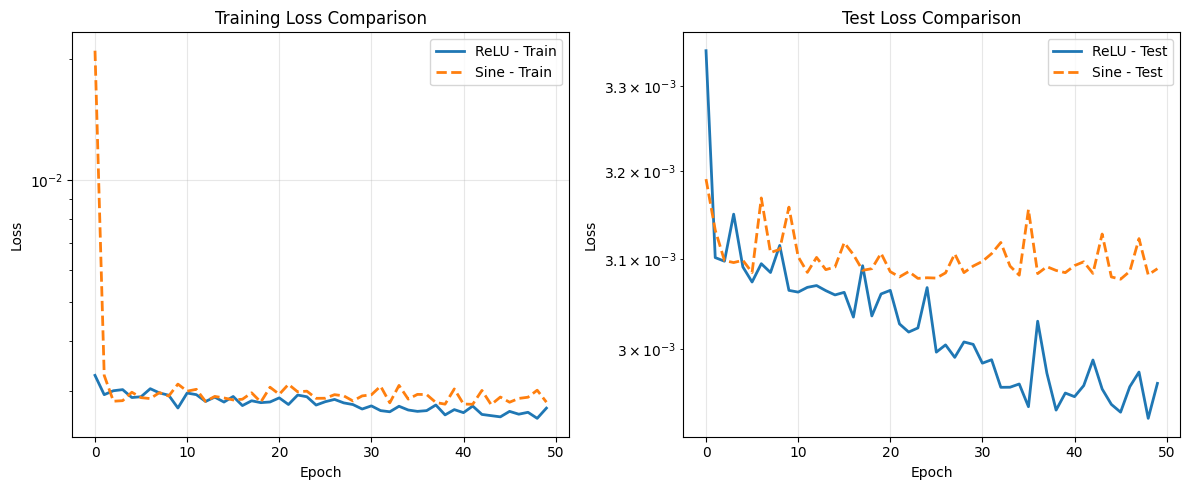


Final Test Loss:
  ReLU: 0.002963
  Sine: 0.003089


In [35]:
# Hyperparameters
input_dim_branch = data_train.u_shape[0]  # From data
input_dim_trunk = 3  # x, y, t coordinates
hidden_dim = 64
output_dim = 64  # latent dimension p
num_hidden_layers = 3
learning_rate = 1e-3
num_epochs = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# SOLUTION: Create model with ReLU activation
branch_relu = BranchNet(input_dim_branch, hidden_dim, output_dim, num_hidden_layers, activation='relu')
trunk_relu = TrunkNet(input_dim_trunk, hidden_dim, output_dim, num_hidden_layers, activation='relu')
model_relu = DeepONet(branch_relu, trunk_relu)

# SOLUTION: Create model with Sine activation
branch_sine = BranchNet(input_dim_branch, hidden_dim, output_dim, num_hidden_layers, activation='sine')
trunk_sine = TrunkNet(input_dim_trunk, hidden_dim, output_dim, num_hidden_layers, activation='sine')
model_sine = DeepONet(branch_sine, trunk_sine)

# Train both models
print("Training model with ReLU activation...")
history_relu = train_deeponet(model_relu, dataloader_train, dataloader_test, num_epochs, learning_rate, device)

print("\nTraining model with Sine activation...")
history_sine = train_deeponet(model_sine, dataloader_train, dataloader_test, num_epochs, learning_rate, device)

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(history_relu['train_loss'], label='ReLU - Train', linewidth=2)
plt.semilogy(history_sine['train_loss'], label='Sine - Train', linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(history_relu['test_loss'], label='ReLU - Test', linewidth=2)
plt.semilogy(history_sine['test_loss'], label='Sine - Test', linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print(f"\nFinal Test Loss:")
print(f"  ReLU: {history_relu['test_loss'][-1]:.6f}")
print(f"  Sine: {history_sine['test_loss'][-1]:.6f}")

### Experiment 6.2: Impact of Fourier Features - SOLUTIONS

Trunk input dim without Fourier features: 3
Trunk input dim with Fourier features: 21

Training model WITHOUT Fourier features...
Epoch [1/50] - Train Loss: 0.003769, Test Loss: 0.003142
Epoch [10/50] - Train Loss: 0.002892, Test Loss: 0.003087
Epoch [20/50] - Train Loss: 0.002896, Test Loss: 0.003057
Epoch [30/50] - Train Loss: 0.002660, Test Loss: 0.003018
Epoch [40/50] - Train Loss: 0.002779, Test Loss: 0.002969
Epoch [50/50] - Train Loss: 0.002607, Test Loss: 0.002980

Training model WITH Fourier features...
Epoch [1/50] - Train Loss: 0.003549, Test Loss: 0.003113
Epoch [10/50] - Train Loss: 0.002746, Test Loss: 0.002964
Epoch [20/50] - Train Loss: 0.002332, Test Loss: 0.002719
Epoch [30/50] - Train Loss: 0.002142, Test Loss: 0.002673
Epoch [40/50] - Train Loss: 0.002213, Test Loss: 0.002614
Epoch [50/50] - Train Loss: 0.002366, Test Loss: 0.002599


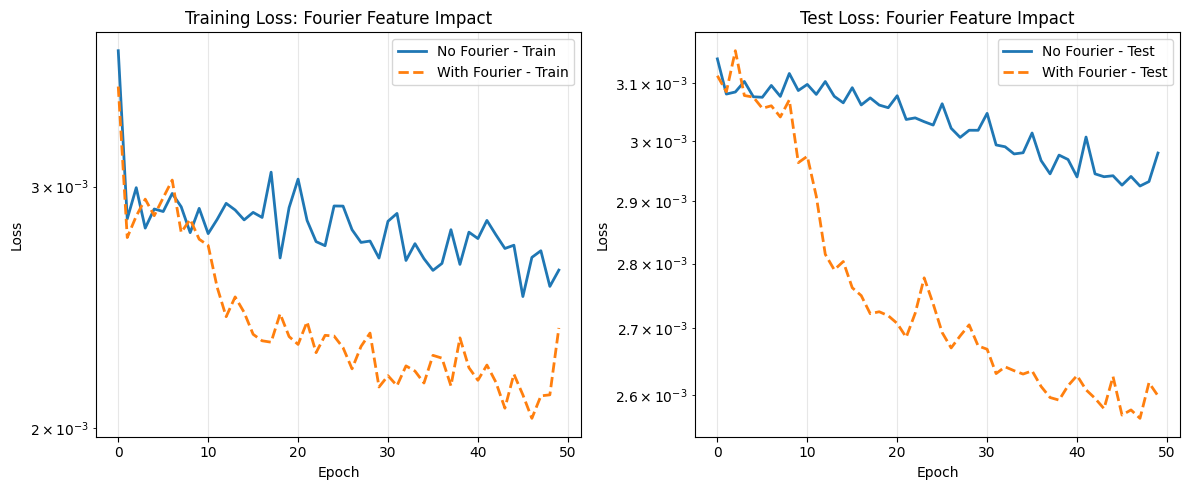


Final Test Loss:
  Without Fourier features: 0.002980
  With Fourier features: 0.002599

Improvement: 12.79%


In [36]:
# SOLUTION: Create feature expansion functions
feat_fn_none = fourier_feature_expansion(freqs=[])
feat_fn_fourier = fourier_feature_expansion(freqs=[1.0, 2.0, 4.0])

# SOLUTION: Create datasets with different feature expansions
dataset_train_none = DatasetStreamer(data_train, batch_size_coord=batch_size_coord, y_feat_extract_fn=feat_fn_none)
dataset_test_none = DatasetStreamer(data_test, batch_size_coord=-1, y_feat_extract_fn=feat_fn_none)

dataset_train_fourier = DatasetStreamer(data_train, batch_size_coord=batch_size_coord, y_feat_extract_fn=feat_fn_fourier)
dataset_test_fourier = DatasetStreamer(data_test, batch_size_coord=-1, y_feat_extract_fn=feat_fn_fourier)

# SOLUTION: Create dataloaders
dataloader_train_none = DataLoader(dataset_train_none, batch_size=batch_size_branch, shuffle=True, 
                                   collate_fn=pytorch_collate, drop_last=True)
dataloader_test_none = DataLoader(dataset_test_none, batch_size=1, shuffle=False, collate_fn=pytorch_collate)

dataloader_train_fourier = DataLoader(dataset_train_fourier, batch_size=batch_size_branch, shuffle=True,
                                      collate_fn=pytorch_collate, drop_last=True)
dataloader_test_fourier = DataLoader(dataset_test_fourier, batch_size=1, shuffle=False, collate_fn=pytorch_collate)

# Get actual input dimensions
sample_none = next(iter(dataloader_train_none))
sample_fourier = next(iter(dataloader_train_fourier))
input_dim_trunk_none = sample_none[0][1].shape[-1]  # Should be 3
input_dim_trunk_fourier = sample_fourier[0][1].shape[-1]  # Should be 3 + 2*3*3 = 21

print(f"Trunk input dim without Fourier features: {input_dim_trunk_none}")
print(f"Trunk input dim with Fourier features: {input_dim_trunk_fourier}")

# SOLUTION: Create models
# Without Fourier features
branch_none = BranchNet(input_dim_branch, hidden_dim, output_dim, num_hidden_layers, activation='relu')
trunk_none = TrunkNet(input_dim_trunk_none, hidden_dim, output_dim, num_hidden_layers, activation='relu')
model_none = DeepONet(branch_none, trunk_none)

# With Fourier features
branch_fourier = BranchNet(input_dim_branch, hidden_dim, output_dim, num_hidden_layers, activation='relu')
trunk_fourier = TrunkNet(input_dim_trunk_fourier, hidden_dim, output_dim, num_hidden_layers, activation='relu')
model_fourier = DeepONet(branch_fourier, trunk_fourier)

# Train and compare
print("\nTraining model WITHOUT Fourier features...")
history_none = train_deeponet(model_none, dataloader_train_none, dataloader_test_none, 
                              num_epochs, learning_rate, device)

print("\nTraining model WITH Fourier features...")
history_fourier = train_deeponet(model_fourier, dataloader_train_fourier, dataloader_test_fourier,
                                 num_epochs, learning_rate, device)

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(history_none['train_loss'], label='No Fourier - Train', linewidth=2)
plt.semilogy(history_fourier['train_loss'], label='With Fourier - Train', linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss: Fourier Feature Impact')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(history_none['test_loss'], label='No Fourier - Test', linewidth=2)
plt.semilogy(history_fourier['test_loss'], label='With Fourier - Test', linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss: Fourier Feature Impact')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print(f"\nFinal Test Loss:")
print(f"  Without Fourier features: {history_none['test_loss'][-1]:.6f}")
print(f"  With Fourier features: {history_fourier['test_loss'][-1]:.6f}")
print(f"\nImprovement: {((history_none['test_loss'][-1] - history_fourier['test_loss'][-1]) / history_none['test_loss'][-1] * 100):.2f}%")

Trunk input dim without Fourier features: 3
Trunk input dim with Fourier features: 21

Training model WITHOUT Fourier features...
Epoch [1/50] - Train Loss: 0.003370, Test Loss: 0.003079
Epoch [10/50] - Train Loss: 0.002929, Test Loss: 0.003083
Epoch [20/50] - Train Loss: 0.002759, Test Loss: 0.003042
Epoch [30/50] - Train Loss: 0.002648, Test Loss: 0.002995
Epoch [40/50] - Train Loss: 0.002906, Test Loss: 0.003000
Epoch [50/50] - Train Loss: 0.002785, Test Loss: 0.002950

Training model WITH Fourier features...
Epoch [1/50] - Train Loss: 0.003122, Test Loss: 0.003094
Epoch [10/50] - Train Loss: 0.002683, Test Loss: 0.002926
Epoch [20/50] - Train Loss: 0.002353, Test Loss: 0.002713
Epoch [30/50] - Train Loss: 0.002162, Test Loss: 0.002687
Epoch [40/50] - Train Loss: 0.002229, Test Loss: 0.002619
Epoch [50/50] - Train Loss: 0.002056, Test Loss: 0.002590


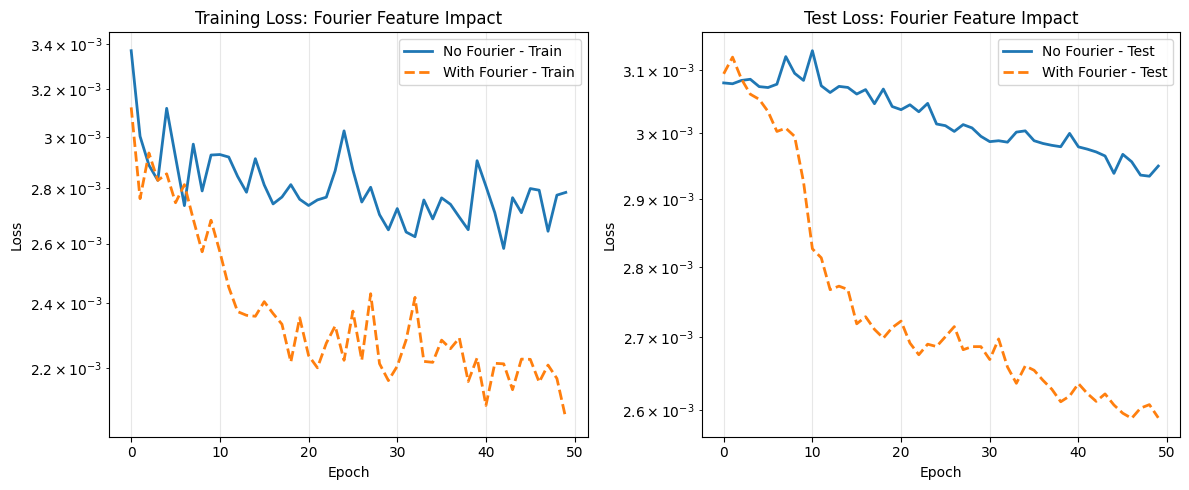


Final Test Loss:
  Without Fourier features: 0.002950
  With Fourier features: 0.002590

Improvement: 12.21%


In [37]:
DatasetStreamer(data_test, batch_size_coord=-1, y_feat_extract_fn=feat_fn_fourier)

# SOLUTION: Create dataloaders
dataloader_train_none = DataLoader(dataset_train_none, batch_size=batch_size_branch, shuffle=True, 
                                   collate_fn=pytorch_collate, drop_last=True)
dataloader_test_none = DataLoader(dataset_test_none, batch_size=1, shuffle=False, collate_fn=pytorch_collate)

dataloader_train_fourier = DataLoader(dataset_train_fourier, batch_size=batch_size_branch, shuffle=True,
                                      collate_fn=pytorch_collate, drop_last=True)
dataloader_test_fourier = DataLoader(dataset_test_fourier, batch_size=1, shuffle=False, collate_fn=pytorch_collate)

# Get actual input dimensions
sample_none = next(iter(dataloader_train_none))
sample_fourier = next(iter(dataloader_train_fourier))
input_dim_trunk_none = sample_none[0][1].shape[-1]  # Should be 3
input_dim_trunk_fourier = sample_fourier[0][1].shape[-1]  # Should be 3 + 2*3*3 = 21

print(f"Trunk input dim without Fourier features: {input_dim_trunk_none}")
print(f"Trunk input dim with Fourier features: {input_dim_trunk_fourier}")

# SOLUTION: Create models
# Without Fourier features
branch_none = BranchNet(input_dim_branch, hidden_dim, output_dim, num_hidden_layers, activation='relu')
trunk_none = TrunkNet(input_dim_trunk_none, hidden_dim, output_dim, num_hidden_layers, activation='relu')
model_none = DeepONet(branch_none, trunk_none)

# With Fourier features
branch_fourier = BranchNet(input_dim_branch, hidden_dim, output_dim, num_hidden_layers, activation='relu')
trunk_fourier = TrunkNet(input_dim_trunk_fourier, hidden_dim, output_dim, num_hidden_layers, activation='relu')
model_fourier = DeepONet(branch_fourier, trunk_fourier)

# Train and compare
print("\nTraining model WITHOUT Fourier features...")
history_none = train_deeponet(model_none, dataloader_train_none, dataloader_test_none, 
                              num_epochs, learning_rate, device)

print("\nTraining model WITH Fourier features...")
history_fourier = train_deeponet(model_fourier, dataloader_train_fourier, dataloader_test_fourier,
                                 num_epochs, learning_rate, device)

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(history_none['train_loss'], label='No Fourier - Train', linewidth=2)
plt.semilogy(history_fourier['train_loss'], label='With Fourier - Train', linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss: Fourier Feature Impact')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(history_none['test_loss'], label='No Fourier - Test', linewidth=2)
plt.semilogy(history_fourier['test_loss'], label='With Fourier - Test', linewidth=2, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss: Fourier Feature Impact')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print(f"\nFinal Test Loss:")
print(f"  Without Fourier features: {history_none['test_loss'][-1]:.6f}")
print(f"  With Fourier features: {history_fourier['test_loss'][-1]:.6f}")
print(f"\nImprovement: {((history_none['test_loss'][-1] - history_fourier['test_loss'][-1]) / history_none['test_loss'][-1] * 100):.2f}%")

### Discussion Questions

After running the experiments, discuss:

1. **Activation Functions**:
   - Which activation (ReLU vs Sine) performed better? Why might this be?
   - How did convergence speed differ between the two?
   - What physical properties of acoustic waves might favor one activation over another?

2. **Fourier Features**:
   - Did Fourier features improve performance? By how much?
   - What is the computational cost of Fourier features (hint: look at input dimensions)?
   - When would you recommend using Fourier features?

3. **DeepONet Architecture**:
   - Why is the operator learning approach useful for PDEs?
   - What are the advantages of DeepONet vs traditional PDE solvers?
   - What are the limitations?

## Summary

This solutions notebook demonstrates:
- ✓ Complete DeepONet implementation in PyTorch
- ✓ Branch and trunk network architectures
- ✓ Inner product operation for operator learning
- ✓ Comparison of ReLU vs Sine activations
- ✓ Impact of Fourier feature expansions
- ✓ Full training and evaluation pipeline

Use this notebook to verify everything works before distributing the student version with TODOs.